In [84]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

In [88]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [89]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [90]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [91]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [92]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [93]:
# Get column names and data types for Measurement table
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [94]:
# Review the information in the Measurement table
first_row = session.query(Measurement).first()
# View the query object as a dictionary and view column names and values for a single row
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1797df43e80>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [95]:
# Get column names and data types for Station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [96]:
# Review the information in the Station table
first_row = session.query(Station).first()
# View the query object as a dictionary and view column names and values for a single row
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1797df50640>,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'id': 1}

# Exploratory Climate Analysis

In [97]:
# TASK 1: Design a query to retrieve the last 12 months of precipitation data and plot the results

In [98]:
# TASK 1, Step 1. Find last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [99]:
# TASK 1, Step 2. Calculate the date 1 year ago from the last data point in the database
last_date = dt.date(2017, 8 ,23)
year_ago = last_date - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [100]:
# TASK 1, Step 3. Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(year_ago, last_date)).all()
date_prcp[:5]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0)]

In [101]:
# TASK 1, Step 4. Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.DataFrame(date_prcp).set_index("date")
date_prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [102]:
# TASK 1, Step 5. Sort the dataframe by date
sort_date_prcp_df = date_prcp_df.sort_values("date")
sort_date_prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


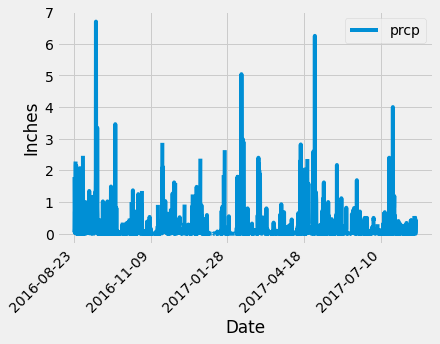

In [103]:
# TASK 1, Step 6. Use Pandas Plotting with Matplotlib to plot the data
sort_date_prcp_df.plot(y = "prcp")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation = "45", horizontalalignment = "right")
plt.show()

In [104]:
# TASK 2: Use Pandas to calcualte the summary statistics for the precipitation data
sort_date_prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [105]:
# TASK 3: Design a query to show how many stations are available in this dataset?
number_stations = session.query(distinct(Measurement.station)).count()
number_stations

9

In [106]:
# TASK 4: What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [107]:
# TASK 5: Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
most_active = "USC00519281"

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).scalar()

print(f"The most active station is {most_active}. The the lowest temperature is {lowest_temp}, highest temperature is {highest_temp}, and average temperature is {avg_temp}.")

The most active station is USC00519281. The the lowest temperature is 54.0, highest temperature is 85.0, and average temperature is 71.66378066378067.


In [108]:
# TASK 6: Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [109]:
# TASK 6, Step 1. Query the last 12 months of temperature observation data for this station
USC00519281_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date.between(year_ago, last_date)).all()
USC00519281_data[:5]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0)]

In [110]:
# TASK 6, Step 2. Save the query results as a Pandas DataFrame and set the index to the date column
USC00519281_data_df = pd.DataFrame(USC00519281_data).set_index("date")
USC00519281_data_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


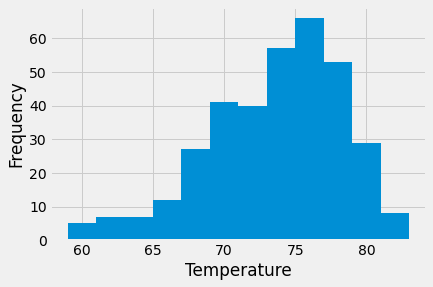

In [111]:
# TASK 6, Step 3. Plot the results as a histogram
plt.hist(USC00519281_data_df["tobs"], bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()